In [2]:
# =======================
# Load the MNIST handwritten digit dataset and return DataLoaders for training and testing.
# Each image is converted to a PyTorch tensor and normalized to the [0, 1] range.
# DataLoaders enable efficient batching, shuffling, and iteration during training.
# =======================
from torchvision import datasets, transforms # Import MNIST dataset and image transforms
from torch.utils.data import DataLoader # For batching and loading the dataset

def get_mnist_loaders(batch_size=128):

  # Convert images to PyTorch tensors with values scaled to [0, 1]
  transform = transforms.ToTensor()

  # Download and load the training dataset
  train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

  # Download and load the test dataset
  test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  # Wrap datasets in DataLoaders to enable batching and shuffling
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader


In [3]:
# =======================
# Visualize a batch of MNIST digit images from the training dataset.
# This function loads a mini-batch using get_mnist_loaders() and displays the digits with their labels.
# Useful for quickly inspecting the raw input data before training.
# =======================
import matplotlib.pyplot as plt # For plotting and displaying images
def visualize_batch(batch_size=16):
  # Load a mini-batch of training data
  train_loader, _ = get_mnist_loaders(batch_size)
  images, labels = next(iter(train_loader)) # Get the first batch

  # Create a horizontal grid of images
  plt.figure(figsize=(10, 4))
  for i in range(batch_size):
    plt.subplot(2, batch_size // 2, i + 1) # 2 rows, batch_size/2 columns
    plt.imshow(images[i][0], cmap='gray') # Show the image (channel 0 since MNIST is grayscale)
    plt.title(f"Label: {labels[i].item()}")
    plt.axis('off')
  plt.tight_layout()
  plt.show()

100%|██████████| 9.91M/9.91M [00:00<00:00, 56.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.62MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.21MB/s]


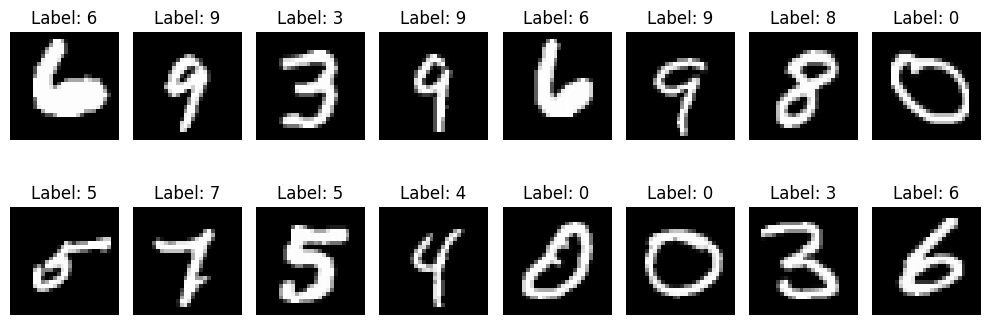

In [4]:
visualize_batch()

\begin{aligned}
D_\text{KL}\left(\rho \,\|\, \hat{\rho}_j^{(l)}\right)
= \rho \log \frac{\rho}{\hat{\rho}_j^{(l)}}
+ (1 - \rho) \log \frac{1 - \rho}{1 - \hat{\rho}_j^{(l)}}
\end{aligned}

In [20]:
# KL Divergence sparsity penalty
def kl_divergence(rho, rho_hat):
  rho_hat = torch.clamp(rho_hat, 1e-6, 1 - 1e-6) # prevent log(0)
  return (rho * torch.log(rho / rho_hat) + (1 - rho) * torch.log((1 - rho) / (1 - rho_hat))).sum()

In [32]:
# =======================
# Define a fully-connected Autoencoder for compressing and reconstructing MNIST digit images.
# Architecture:
#   Encoder: 784 → 128 → 32
#   Decoder: 32 → 128 → 784
# The model learns to compress 28x28 images into a 32-dimensional latent space and reconstruct them.
# =======================
import torch
import torch.nn as nn
class Autoencoder(nn.Module):
  def __init__(self, input_dim=784, hidden_dim=128, latent_dim=32):
    super().__init__()

    # Encoder: compress input image to a 32-dimensional latent vector
    self.encoder = nn.Sequential(
        nn.Linear(input_dim, hidden_dim), # Flattened image → hidden layer
        nn.ReLU(),
        nn.Linear(hidden_dim, latent_dim), # Hidden → latent representation
        nn.Sigmoid() # To ensure the latent vector is between 0 and 1
    )

    # Decoder: reconstruct image from the latent vector
    self.decoder = nn.Sequential(
        nn.Linear(latent_dim, hidden_dim), # Latent → hidden layer
        nn.ReLU(),
        nn.Linear(hidden_dim, input_dim), # Hidden → reconstructed image
        nn.Sigmoid(),  # Match MNIST pixel range [0, 1]
    )

  def forward(self, x):
    x = x.view(x.size(0), -1) # Flatten image: [batch, 1, 28, 28] → [batch, 784]
    z = self.encoder(x) # Encode to latent vector
    out = self.decoder(z) # Decode back to reconstructed image
    return out, z # return the latent vector too so that we can compute sparsity

In [33]:
train_loader, test_loader = get_mnist_loaders()

In [34]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Autoencoder()
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): Sigmoid()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [35]:
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [40]:
# Train model
epochs = 10
rho = 0.05 # target sparsity
beta = 5e-3 # sparsity weight
model.train()
for epoch in range(epochs):
  running_loss = 0.0
  for data in train_loader:
    inputs, _ = data
    inputs = inputs.to(device)
    optim.zero_grad()
    outputs, latent_vector = model(inputs) # the latent vector is also a hidden layer
    recon_loss = criterion(outputs, inputs.view(inputs.size(0), -1))
    rho_hat = latent_vector.mean(dim=0)
    sparsity_loss = kl_divergence(rho, rho_hat)
    loss = recon_loss + beta*sparsity_loss
    loss.backward()
    optim.step()
    running_loss += loss.item()
  avg_loss = running_loss/len(train_loader)
  print(f"Epoch {epoch+1}, Recon Loss: {recon_loss.item():.4f}, Sparsity Loss: {sparsity_loss.item():.4f}, Avg Loss: {avg_loss:.4f}")

Epoch 1, Recon Loss: 0.0167, Sparsity Loss: 0.2775, Avg Loss: 0.0201
Epoch 2, Recon Loss: 0.0178, Sparsity Loss: 0.2136, Avg Loss: 0.0189
Epoch 3, Recon Loss: 0.0177, Sparsity Loss: 0.1303, Avg Loss: 0.0181
Epoch 4, Recon Loss: 0.0164, Sparsity Loss: 0.1458, Avg Loss: 0.0174
Epoch 5, Recon Loss: 0.0163, Sparsity Loss: 0.1364, Avg Loss: 0.0168
Epoch 6, Recon Loss: 0.0159, Sparsity Loss: 0.0842, Avg Loss: 0.0163
Epoch 7, Recon Loss: 0.0149, Sparsity Loss: 0.0913, Avg Loss: 0.0158
Epoch 8, Recon Loss: 0.0147, Sparsity Loss: 0.0794, Avg Loss: 0.0154
Epoch 9, Recon Loss: 0.0140, Sparsity Loss: 0.0841, Avg Loss: 0.0151
Epoch 10, Recon Loss: 0.0135, Sparsity Loss: 0.0687, Avg Loss: 0.0147


In [41]:
# Test model
model.eval()
with torch.no_grad():
  test_loss = 0.0
  for data in test_loader:
    inputs, _ = data
    inputs = inputs.to(device)
    outputs, _ = model(inputs)
    loss = criterion(outputs, inputs.view(inputs.size(0), -1))
    test_loss += loss.item()
  print(f'Test Loss: {test_loss / len(test_loader)}')


Test Loss: 0.013869156719102889


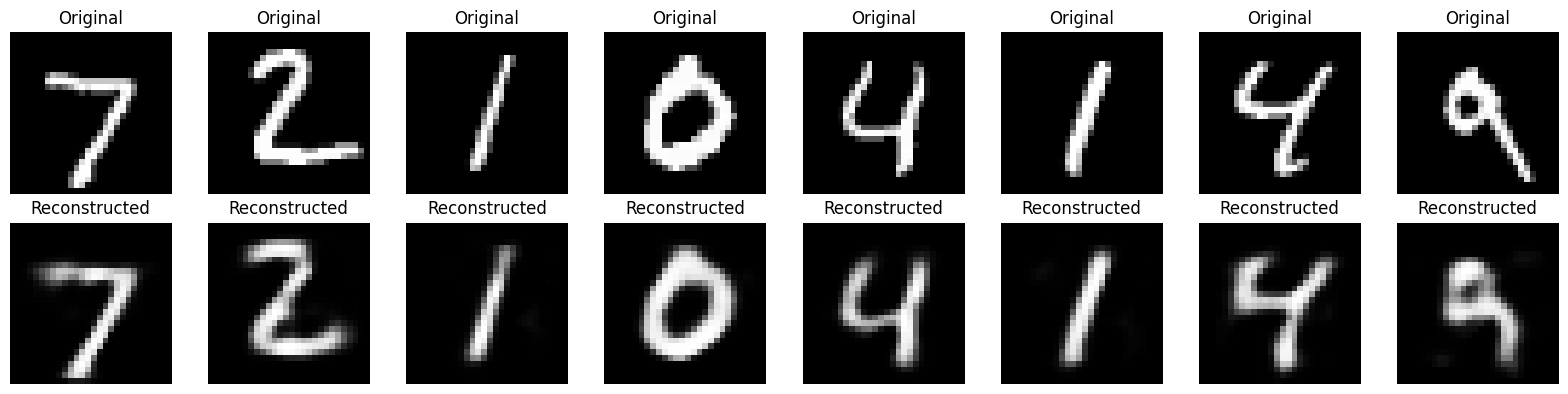

In [42]:
# Get a small batch
model.eval()
with torch.no_grad():
    sample_imgs, _ = next(iter(test_loader))
    sample_imgs = sample_imgs.to(device)
    reconstructed, _ = model(sample_imgs)

# Plot original vs reconstructed
n = 8
plt.figure(figsize=(16, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(sample_imgs[i][0].cpu(), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].view(28, 28).cpu(), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()


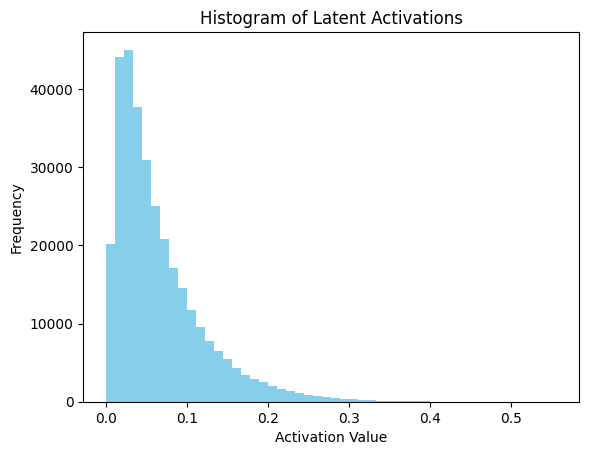

In [43]:
# Shows the overall distribution (should be skewed toward 0):
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    all_latents = []
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        _, latent = model(inputs)
        latent = latent.to('cpu')
        all_latents.append(latent)
    all_latents = torch.cat(all_latents)

plt.hist(all_latents.flatten().numpy(), bins=50, color='skyblue')
plt.title("Histogram of Latent Activations")
plt.xlabel("Activation Value")
plt.ylabel("Frequency")
plt.show()


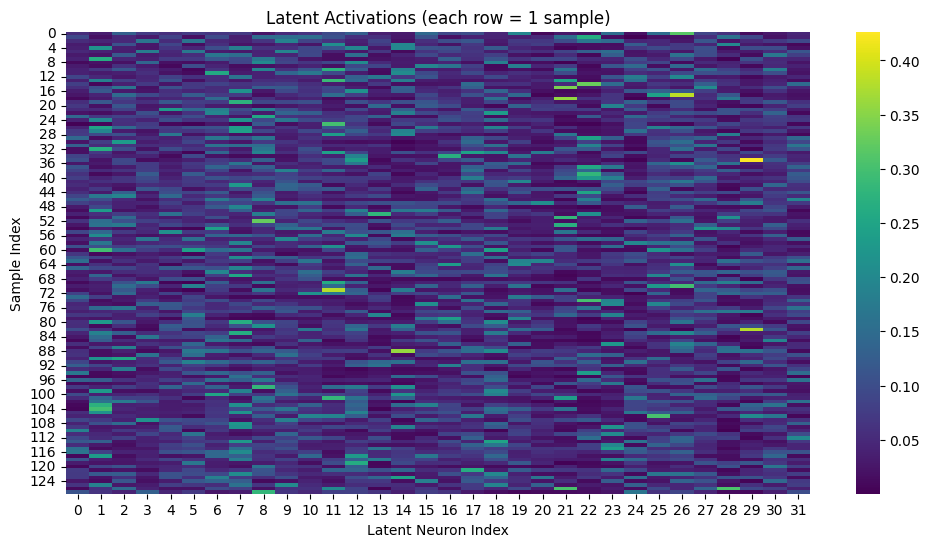

In [44]:
import seaborn as sns

model.eval()
with torch.no_grad():
    inputs, _ = next(iter(test_loader))
    inputs = inputs.to(device)
    _, latents = model(inputs)
    latents = latents.cpu().numpy()

plt.figure(figsize=(12, 6))
sns.heatmap(latents, cmap='viridis')
plt.title("Latent Activations (each row = 1 sample)")
plt.xlabel("Latent Neuron Index")
plt.ylabel("Sample Index")
plt.show()


In [45]:
print("Mean activation per latent neuron:")
print(latents.mean(axis=0))

Mean activation per latent neuron:
[0.05881437 0.08356344 0.06890944 0.05662598 0.06295422 0.07214342
 0.08306798 0.08962519 0.08328992 0.07404667 0.06917366 0.07323428
 0.0833219  0.05312702 0.06850568 0.06678353 0.0656389  0.07452542
 0.08268029 0.06249533 0.04544028 0.06367793 0.06402301 0.06478576
 0.06190737 0.07323104 0.08654048 0.07135439 0.05962756 0.0592905
 0.06936473 0.06037938]
